In [39]:
import mne
import os
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from scipy.signal import resample
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
import pyxdf
import re
from statistics import mean
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_rel

In [2]:
xdf_path = 'eeg/sub-007_ses-exp1_task-Default_run-001_eeg.xdf'
participant = '007'
data, header = pyxdf.load_xdf(xdf_path)

In [3]:
eeg_stream, marker_stream = None, None
for i, stream in enumerate(data):
    print(f'stream {i}: {stream['info']['name'][0]} - {stream['info']['type'][0]}')
    if stream['info']['name'][0] == 'eeg':
        eeg_stream = stream
    if stream['info']['name'][0] == 'LuckyMarkerStream':
        marker_stream = stream

#raise error if no stream
if eeg_stream == None:
    raise ValueError('no eeg stream')
if marker_stream == None:
    raise ValueError('no marker stream') 


stream 0: LuckyMarkerStream - Markers
stream 1: eeg - data


In [4]:
marker_stream['time_series']

[['experimentStarted'],
 ['spin 1'],
 ['oil_1.jpg'],
 ['-1'],
 ['rating -1'],
 ['spin 2'],
 ['crackers_1.jpg'],
 ['rating 0'],
 ['spin 3'],
 ['Loose2€_1.jpg'],
 ['-1'],
 ['rating -1'],
 ['spin 4'],
 ['bike_tour_1.jpg'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 5'],
 ['Loose0€_1.jpg'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 6'],
 ['burger_1.jpg'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 7'],
 ['set_1_prompt_3_1.png'],
 ['-1'],
 ['rating -1'],
 ['spin 8'],
 ['chips_1.jpg'],
 ['1'],
 ['rating 1'],
 ['spin 9'],
 ['walk_1.jpg'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 4'],
 ['spin 10'],
 ['beer_1.jpg'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 11'],
 ['set_57_prompt_1.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 12'],
 ['set_81_prompt_1_1.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 13'],
 ['set_51_prompt_2_1.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 [

In [5]:
len(marker_stream['time_series'])

668

In [6]:
#collect personal images and time stamps 
markers = marker_stream['time_series']
timestamps = marker_stream['time_stamps']
markers_ts_zip = zip(markers, timestamps)
personal_mask = [i for i, x in enumerate(markers) if 'set' in x[0]]
general_mask = [i for i, x in enumerate(markers) if 'jpg' in x[0]]

response_times_personal = []
for i in personal_mask:
    #print(markers[i], markers[i+1], timestamps[i], timestamps[i+1], timestamps[i+1] - timestamps[i])
    response_times_personal.append(timestamps[i+1] - timestamps[i])

response_times_general = []
for i in general_mask: 
    response_times_general.append(timestamps[i+1] - timestamps[i])


In [7]:
def equal_lists(l1, l2): 
    length = max(len(l1), len(l2))

    l1 += [mean(l1)] * (length - len(l1))
    l2 += [mean(l2)] * (length - len(l2))
    print(len(l1), len(l2))
    return l1, l2

In [8]:
print(response_times_general, response_times_general)
print(len(response_times_general), len(response_times_personal))

response_times_personal = list(response_times_personal)
response_times_general = list(response_times_general)

if len(response_times_general) != len(response_times_personal):
    
    length = max(len(response_times_general), len(response_times_personal))
    #difference = length - min(len(response_times_general), len(response_times_personal))
    response_times_personal += [mean(response_times_personal)] * (length - len(response_times_personal))
    response_times_general += [mean(response_times_general)] * (length - len(response_times_general))

print(len(response_times_general), len(response_times_personal))

#if len(response_times_general) > len(response_times_personal):
    

[np.float64(8.72597839217633), np.float64(5.606939794495702), np.float64(5.04665379691869), np.float64(2.672111297957599), np.float64(3.035658497363329), np.float64(2.3758784979581833), np.float64(4.633454296737909), np.float64(2.557298398576677), np.float64(2.9356779968366027), np.float64(2.675675696693361), np.float64(2.6749202981591225), np.float64(2.9508894979953766), np.float64(2.3580896984785795), np.float64(1.9189907982945442), np.float64(1.9684940986335278), np.float64(2.0427493983879685), np.float64(1.912897097878158), np.float64(3.6328169964253902), np.float64(2.3084550984203815), np.float64(6.052196694537997), np.float64(1.9247191976755857), np.float64(2.499146197922528), np.float64(2.6143163982778788), np.float64(1.9593604980036616), np.float64(3.0589326974004507), np.float64(3.546642997302115), np.float64(1.8641865979880095), np.float64(4.998925095424056), np.float64(1.9886076990514994), np.float64(6.136843194253743), np.float64(2.01532899774611), np.float64(4.872716195881

In [9]:
response_times_general, response_times_personal = equal_lists(response_times_general, response_times_personal)

57 57


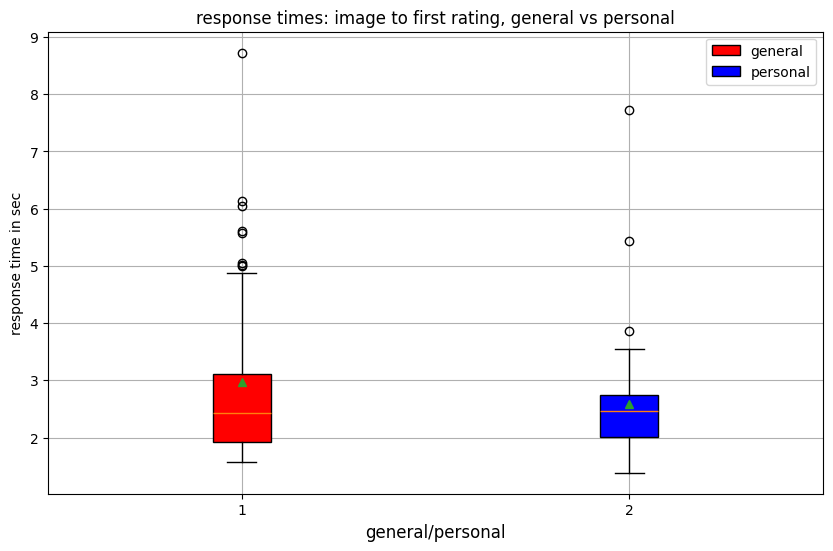

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue']
bplot = ax.boxplot([response_times_general, response_times_personal], label=['general', 'personal'], showmeans=True, patch_artist=True)
ax.set_xlabel('general/personal', fontsize=12)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.grid(True)
ax.legend()
ax.set_title('response times: image to first rating, general vs personal')
ax.set_ylabel('response time in sec')
#show
plt.show()

50 57
50 57
57 57


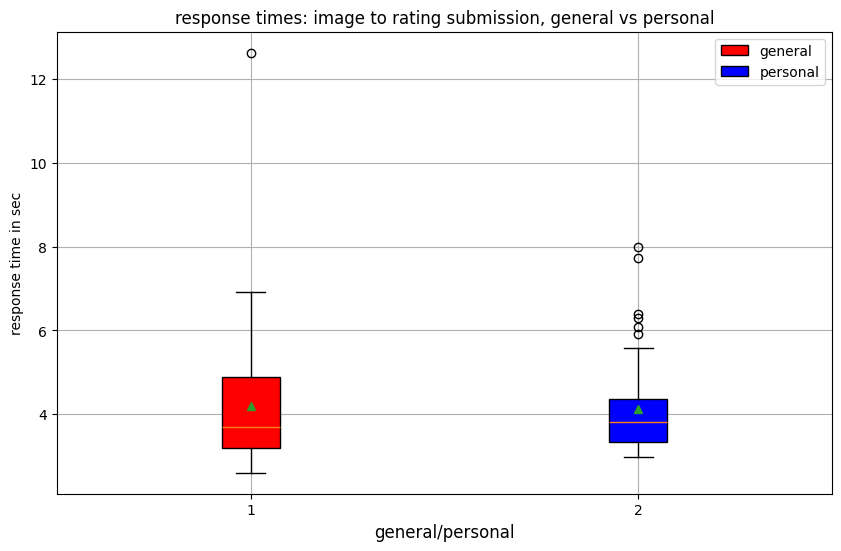

In [11]:
#response times from image until submitted rating 
personal_mask
general_mask
markers_ts_zip
ratings = [i for i, x in enumerate(markers) if 'rating' in x[0]]
personal_rating_index = []
general_rating_index = []

pairs = []
personal = False
#collect rating and image, rating and index pairs to find rating ts (jpg -> general)
for i, m in enumerate(markers):
    if 'jpg' in m[0]: 
        image = m[0]
        personal = False
    if 'png' in m[0]:
        image = m[0]
        personal = True
    if 'rating' in m[0]:
        rating = m[0]
        rating_ts = i
        pairs.append((rating_ts, personal))

#get timestamp indices for rating submission
personal_rating_index = [index for index, p in pairs if p]
general_rating_index = [index for index, p in pairs if not p]

#get stimulus show timestamps
personal_stim_ts = timestamps[personal_mask]
general_stim_ts = timestamps[general_mask]

#get rating timestamps
personal_rating_ts = timestamps[personal_rating_index]
general_rating_ts = timestamps[general_rating_index]

#check sizes
print(len(personal_stim_ts), len(general_stim_ts))
print(len(personal_rating_ts), len(general_rating_ts))

#collect differences between stimulus show time and final rating submission
personal_response_time_diff = []
for i, ts in enumerate(personal_stim_ts):
    personal_response_time_diff.append(personal_rating_ts[i] - ts)

general_response_time_diff = []
for i, ts in enumerate(general_stim_ts):
    general_response_time_diff.append(general_rating_ts[i] - ts)
    
#ensure equal length
personal_response_time_diff = list(personal_response_time_diff)
general_response_time_diff = list(general_response_time_diff)
personal_times, general_times = equal_lists(personal_response_time_diff, general_response_time_diff)

#create graph
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue']
bplot = ax.boxplot([general_times, personal_times], label=['general', 'personal'], showmeans=True, patch_artist=True)
ax.set_xlabel('general/personal', fontsize=12)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.grid(True)
ax.legend()
ax.set_title('response times: image to rating submission, general vs personal')
ax.set_ylabel('response time in sec')
#show
plt.show()



In [12]:
data, header = pyxdf.load_xdf(f'eeg/sub-008_ses-behavioral01_task-Default_run-001_eeg.xdf')

eeg_stream, marker_stream = None, None
for i, stream in enumerate(data):
    #print(f'{f} -- stream {i}: {stream['info']['name'][0]} - {stream['info']['type'][0]}')
    #if stream['info']['name'][0] == 'eeg':
    #    eeg_stream = stream
    if stream['info']['name'][0] == 'LuckyMarkerStream':
        marker_stream = stream 

marker_stream['time_series']

[['experimentStarted'],
 ['spin 1'],
 ['set_8_prompt_2_4.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 4'],
 ['spin 2'],
 ['chips_1.jpg'],
 ['1'],
 ['1'],
 ['rating 2'],
 ['spin 3'],
 ['set_24_prompt_2_2.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 4'],
 ['set_4_prompt_3_2.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 5'],
 ['set_59_prompt_2_1.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['-1'],
 ['1'],
 ['rating 4'],
 ['spin 6'],
 ['acorns_1.jpg'],
 ['-1'],
 ['-1'],
 ['1'],
 ['1'],
 ['rating 0'],
 ['spin 7'],
 ['set_62_prompt_1_3.png'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['rating 5'],
 ['spin 8'],
 ['set_95.png'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['rating -5'],
 ['spin 9'],
 ['vinegar_1.jpg'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['rating -5'],
 ['spin 10'],
 ['bag_of_leaves_1.jpg'],
 ['-1'],
 ['-1'],
 ['1'],
 

In [13]:
'''
REACTION TIMES POOLED
reaction times per participant from image until first button press
split between positive and negative
all participants --> one plot, not pooled
'''
participants = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011']
path = 'eeg/'
participant_files = [x for x in os.listdir(path) if x[x.find('-') + 1: x.find('_')] in participants]

#create datastructure
participant_data = {}
for p in participants:
    participant_data[p] = {}

#load files 
for f in participant_files:
    participant = f[f.find('-') + 1 : f.find('_')]
    data, header = pyxdf.load_xdf(f'{path}{f}')
    eeg_stream, marker_stream = None, None
    for i, stream in enumerate(data):
        print(f'{f} -- stream {i}: {stream['info']['name'][0]} - {stream['info']['type'][0]}')
        #if stream['info']['name'][0] == 'eeg':
        #    eeg_stream = stream
        if stream['info']['name'][0] == 'LuckyMarkerStream':
            marker_stream = stream         

        zipped_data = zip(marker_stream['time_series'], marker_stream['time_stamps'])
        #participant_data[participant]['time_series'] = marker_stream['time_series']
        #participant_data[participant]['time_stamps'] = marker_stream['time_stamps']
        participant_data[participant] = zipped_data


for participant in participant_data:
    #make sure only filled data is loaded
    if participant_data[participant] == {}: continue
    #print(participant)
    for marker, ts in participant_data[participant]:
        print(marker, ts)
        

sub-002_ses-S001_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-002_ses-S001_task-Default_run-001_eeg.xdf -- stream 1: eeg - data
sub-003_ses-S003_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-003_ses-S003_task-Default_run-001_eeg.xdf -- stream 1: eeg - data
sub-004_ses-S001_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-004_ses-S001_task-Default_run-001_eeg.xdf -- stream 1: eeg - data


Stream 2: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.


sub-005_ses-S001_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-005_ses-S001_task-Default_run-001_eeg.xdf -- stream 1: eeg - data
sub-005_ses-S001_task-Default_run-001_eeg.xdf -- stream 2: eeg - data
sub-006_ses-002_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-006_ses-002_task-Default_run-001_eeg.xdf -- stream 1: eeg - data
sub-007_ses-exp1_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-007_ses-exp1_task-Default_run-001_eeg.xdf -- stream 1: eeg - data
sub-008_ses-behavioral01_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-009_ses-behavioural01_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-010_ses-behavoiral01_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
sub-011_ses-behavioral02_task-Default_run-001_eeg.xdf -- stream 0: LuckyMarkerStream - Markers
['experimentStarted'] 553292.901504185
['spin 1'] 553292.901780185
['present_1.j

In [14]:
'''INDIVIDUAL RATINGS'''


'INDIVIDUAL RATINGS'

In [15]:
#collect personal images and time stamps 
markers = marker_stream['time_series']
timestamps = marker_stream['time_stamps']
markers_ts_zip = zip(markers, timestamps)
personal_mask = [i for i, x in enumerate(markers) if 'set' in x[0]]
general_mask = [i for i, x in enumerate(markers) if 'jpg' in x[0]]

response_times_personal = []
for i in personal_mask:
    #print(markers[i], markers[i+1], timestamps[i], timestamps[i+1], timestamps[i+1] - timestamps[i])
    response_times_personal.append(timestamps[i+1] - timestamps[i])

response_times_general = []
for i in general_mask: 
    response_times_general.append(timestamps[i+1] - timestamps[i])

57 57
57 57
59 59


Stream 2: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.


57 57
57 57
57 57
57 57
57 57
57 57
57 57
participant		T-stat		P-value
002		2.3851		0.0205		True
003		2.3850		0.0205		True
004		-0.4326		0.6669		False
005		3.2196		0.0021		True
006		1.8876		0.0643		False
007		1.9256		0.0592		False
008		2.2965		0.0254		True
009		-0.6675		0.5072		False
010		0.7131		0.4788		False
011		0.6084		0.5454		False


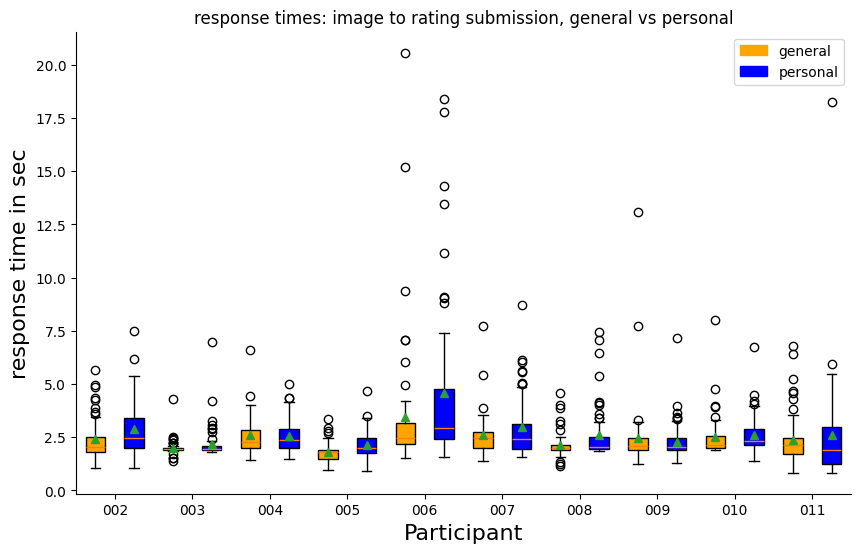

In [40]:
'''reaction times per participant from image until first button press
split between positive and negative
all participants --> one plot, not pooled
'''

path = 'figures/' 
participants = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011']
path = 'eeg/'
participant_files = [x for x in os.listdir(path) if x[x.find('-') + 1: x.find('_')] in participants]
#create datastructure
participant_data = {}
for p in participants:
    participant_data[p] = {}
#load files 
for f in participant_files:
    participant = f[f.find('-') + 1 : f.find('_')]
    data, header = pyxdf.load_xdf(f'{path}{f}')
    eeg_stream, marker_stream = None, None
    for i, stream in enumerate(data):
        #print(f'{f} -- stream {i}: {stream['info']['name'][0]} - {stream['info']['type'][0]}')
        #if stream['info']['name'][0] == 'eeg':
        #    eeg_stream = stream
        if stream['info']['name'][0] == 'LuckyMarkerStream':
            marker_stream = stream        
            timestamps = marker_stream['time_stamps']
            markers = marker_stream['time_series']
            general = [] 
            personal = [] 
            
            for i, m in enumerate(markers): 
                if 'jpg' in m[0]: 
                    general.append(timestamps[i + 1] - timestamps[i]) 
                if 'png' in m[0]:
                    personal.append(timestamps[i + 1] - timestamps[i])
            personal_times, general_times = equal_lists(personal, general)

            #data needs to be in lists according to general or personal data
            participant_data[participant] = {'general' : general_times, 'personal': personal_times}
            
#remove empty keys 
to_pop = []
for p in participant_data:
    if participant_data[p] == {}: 
        to_pop.append(p)
for x in to_pop:
    participant_data.pop(x, None)  

#create lists because i didnt realise it needed to be in a list to work and now i dont want to rewrite everything
#just realized it doesnt work becuase it gets 2 lists :( 
to_plot = []
labels = []
colors = []
for p in participant_data:
    #general_data.append(participant_data[p]['general'])
    #personal_data.append(participant_data[p]['personal'])
    to_plot.append(participant_data[p]['personal'])
    to_plot.append(participant_data[p]['general'])
    labels.extend([f'{p}-gen', f'{p}-per'])
    colors.extend(['orange', 'blue'])

#print(participant_data)
significance = []
personal_data_test, general_data_test = [], []
print("participant\t\tT-stat\t\tP-value")
for p in participant_data:
    t_stat, p_val = ttest_rel(participant_data[p]['general'], participant_data[p]['personal'])
    print(f"{p}\t\t{t_stat:.4f}\t\t{p_val:.4f}\t\t{p_val < 0.05}")
    significance.append(p_val < 0.05)
    general_data_test.extend(participant_data[p]['general'])
    personal_data_test.extend(participant_data[p]['personal'])
    
#print(len(to_plot), len(labels))

#get participant codes from labels
participants = [x.split('-')[0] for i, x in enumerate(labels) if i%2 == 0]
pos = np.arange(1.5, len(labels) + 0.5, 2)
#create graph
fig, ax = plt.subplots(figsize=(10, 6))
bplot = ax.boxplot(to_plot, label=labels, showmeans=True, patch_artist=True)
ax.set_xlabel('personal/general', fontsize=12)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#ax.grid(True)
#ax.legend()
ax.set_title('response times: image to rating submission, general vs personal')
ax.set_ylabel('response time in sec', fontsize = 16)

ax.set_xticks(pos)
ax.set_xticklabels(participants, rotation=45)
ax.set_xlabel('Participant', fontsize=16)
orange_patch = mpatches.Patch(color='orange', label='general')
blue_patch = mpatches.Patch(color='blue', label='personal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
ax.spines['right'].set_position(('outward', 100)) 
# Add the simplified legend
ax.legend(handles=[orange_patch, blue_patch], loc='upper right')
#show
plt.savefig('figures/reaction_times_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
t_stat, p_val = ttest_rel(general_data_test, personal_data_test)
print(f"{p}\t\t{t_stat:.4f}\t\t{p_val:.4f}\t\t{p_val < 0.05}")

011		3.5222		0.0005		True


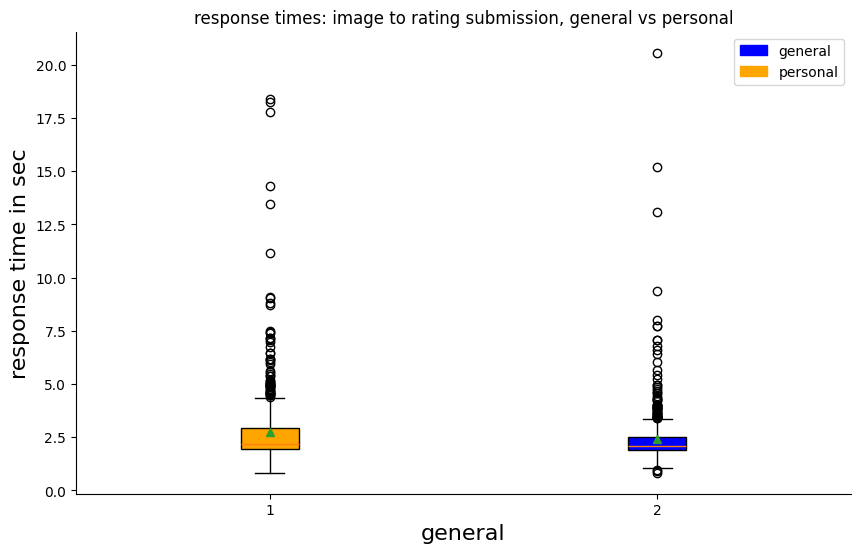

In [37]:
overall_times = []
overall_times.append(general_data_test)
overall_times.append(personal_data_test)

fig, ax = plt.subplots(figsize=(10, 6))
bplot = ax.boxplot(overall_times, label=['general', 'personal'], showmeans=True, patch_artist=True)
ax.set_xlabel('personal/general', fontsize=12)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#ax.grid(True)
#ax.legend()
ax.set_title('response times: image to rating submission, general vs personal')
ax.set_ylabel('response time in sec', fontsize = 16)
ax.set_xlabel('general', fontsize=16)
orange_patch = mpatches.Patch(color='blue', label='general')
blue_patch = mpatches.Patch(color='orange', label='personal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_position(('outward', 100))  # Add padding to the bottom
ax.spines['right'].set_position(('outward', 100)) 
# Add the simplified legend
ax.legend(handles=[orange_patch, blue_patch], loc='upper right')
#show
#plt.savefig('figures/reaction_times_all.png', dpi=300, bbox_inches='tight')
plt.show()